In [91]:
import pandas as pd
import numpy as np

from scipy import signal
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns

import random

In [92]:
# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)

Random Seed:  999


In [93]:
gw_df = pd.read_csv('../data/input/richers_1764.csv')

# y-axis processing
# distance = 3.086e22
# gw_df = gw_df / distance

# x-axis processing
# for future use
# sampling_period = 0.00024354078

In [94]:
parameters_df = pd.read_csv('../data/input/richers_1764_parameters.csv')
selected_indexes = parameters_df[parameters_df['beta1_IC_b'] > 0].index
gw_df = gw_df.iloc[:, selected_indexes]
gw_df = gw_df.iloc[(407-256):407, :]

print(gw_df.shape)

(256, 1684)


### Signal Analysis

#### PCA on Signals

This is to just select any one of the pcas.

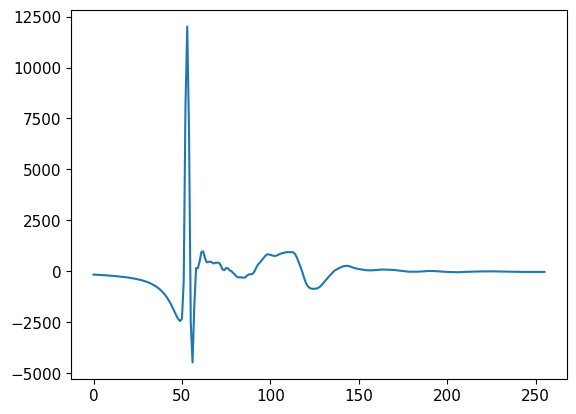

In [95]:
gw_pca_df = gw_df
gw_pca_df = gw_pca_df.values

pca = PCA(n_components = 1)
 
gw_pca_df = pca.fit_transform(gw_pca_df)

plt.plot(gw_pca_df[:,0])

plt.show()
print()

In [96]:
# # select first 16 pca
# selected_pca = gw_pca_df[:,0:16]

# num_rows = 4
# num_cols = 4

# # Determine the common limits for all subplots
# common_ylim = (selected_pca.min().min(), selected_pca.max().max())

# fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 12))

# axes = axes.flatten()

# # plot each signal on a separate subplot
# for i, ax in enumerate(axes):
#     x = np.arange(len(selected_pca))
#     y = selected_pca[:, i]
#     ax.plot(x, y)

#     ax.axvline(x=203, color='black', linestyle='--', alpha=0.5)
#     ax.set_title(f'Signal {i}')
#     ax.grid(True)
#     ax.set_ylim(common_ylim)

# for i in range(len(selected_signals), num_rows*num_cols):
#     fig.delaxes(axes[i])

# plt.tight_layout()
# plt.show()

Shape appears consistent with what we expect for core-bounce plus post-bounce occilations, but why are the values so high?

### Plot of "mean" of data

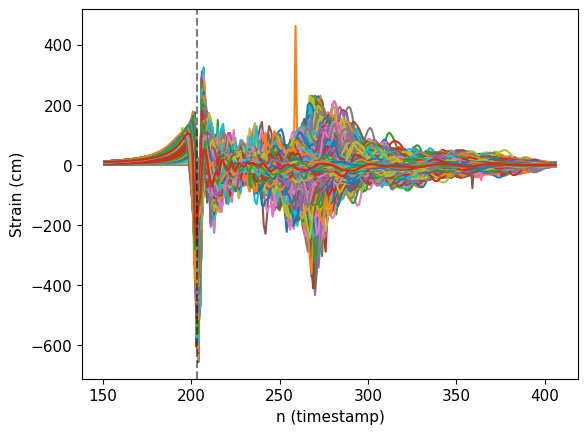

In [97]:
gw_df.plot(legend=False)

plt.xlabel('n (timestamp)')
plt.ylabel('Strain (cm)')

# the core bounce is at n = 203
plt.axvline(x=203, color='black', linestyle='--', alpha=0.5)

plt.show()

I'm not sure whether this is a good statistic

#### 16 Random Signals

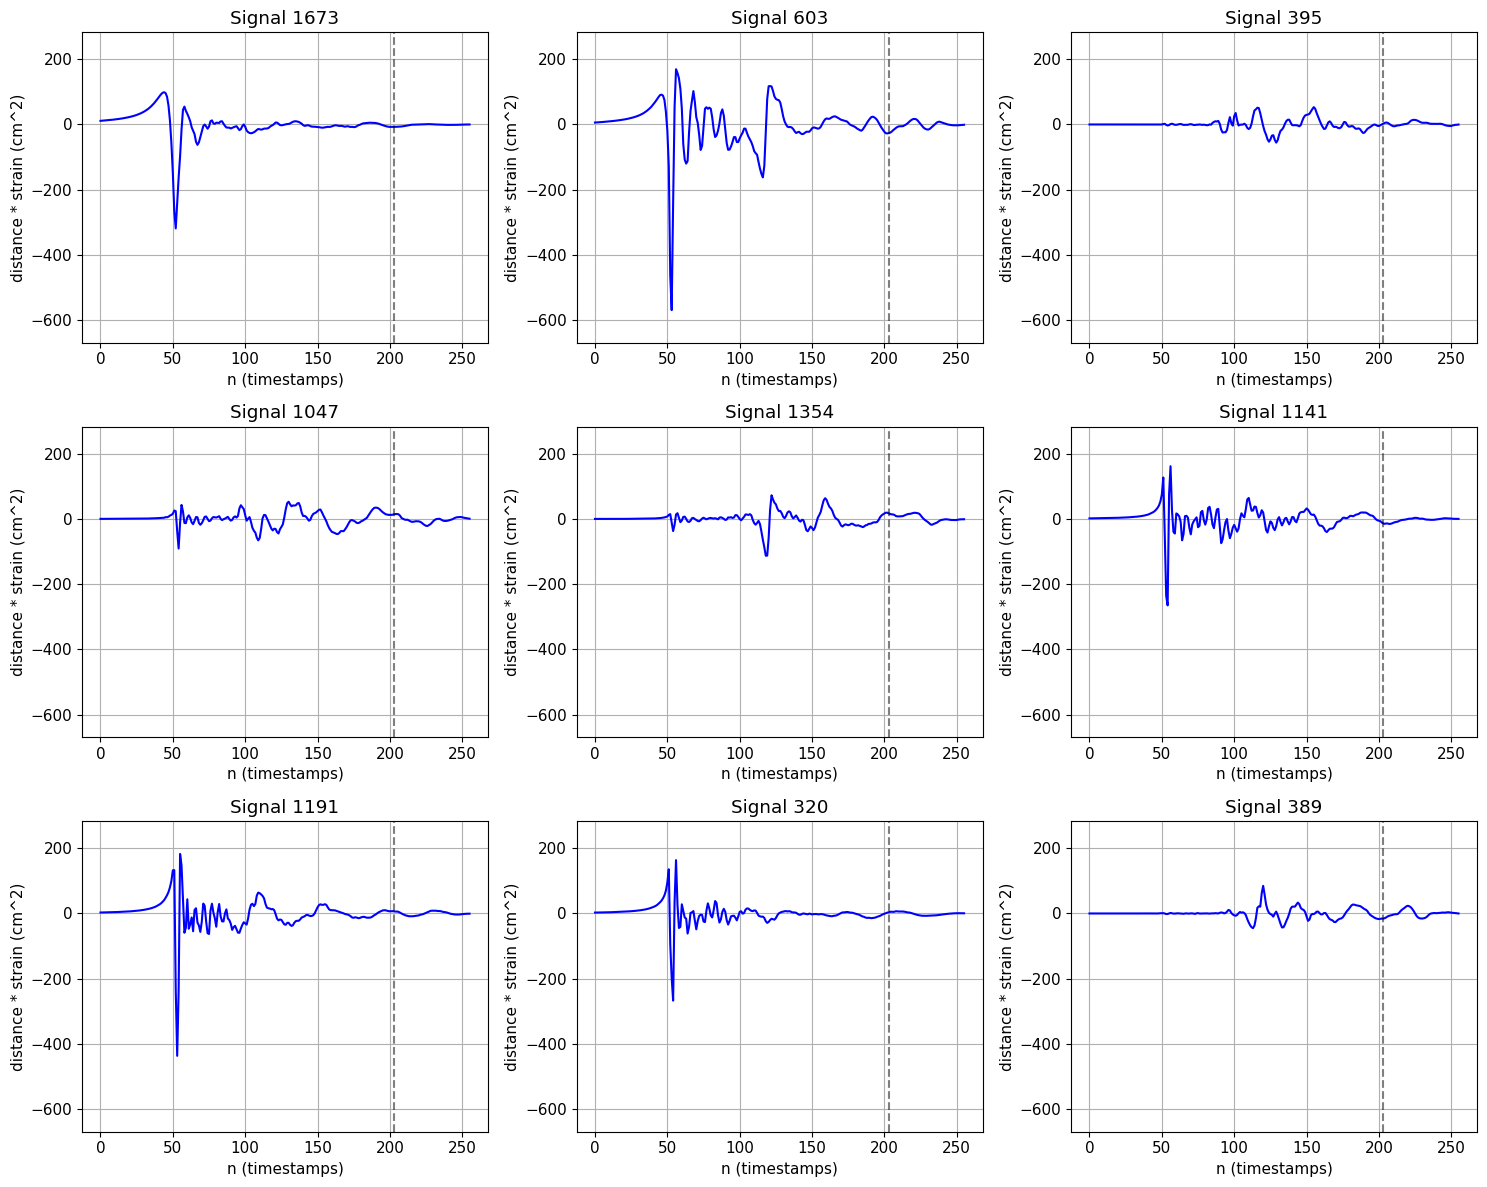

In [98]:
# select 16 random signals
random_index = np.random.randint(0, gw_df.shape[1], 9)
selected_signals = gw_df.iloc[:, random_index]  # Assuming the first 64 columns are the signals

num_rows = 3
num_cols = 3

# Determine the common limits for all subplots
common_ylim = (selected_signals.min().min() - 100, selected_signals.max().max() + 100)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 12))

axes = axes.flatten()

# plot each signal on a separate subplot
for i, ax in enumerate(axes):
    x = np.arange(len(selected_signals))
    y = selected_signals.iloc[:, i]
    ax.plot(x, y, color='blue')

    ax.axvline(x=203, color='black', linestyle='--', alpha=0.5)
    ax.set_title(f'Signal {random_index[i]}')
    ax.grid(True)
    ax.set_ylim(common_ylim)
    
    # Add axis titles
    ax.set_ylabel('distance * strain (cm^2)')
    ax.set_xlabel('n (timestamps)')

for i in range(len(selected_signals), num_rows*num_cols):
    fig.delaxes(axes[i])

plt.tight_layout()
# plt.savefig('../plots/gw_signals_sample_16_signals.png')
plt.show()


- All signals appear significantly different from one another
- There appears to be a common peak at n = 203 (core bounce)
- The core bounce is NOT necessarily the peak strain for each signal

#### General Distribution of Signals

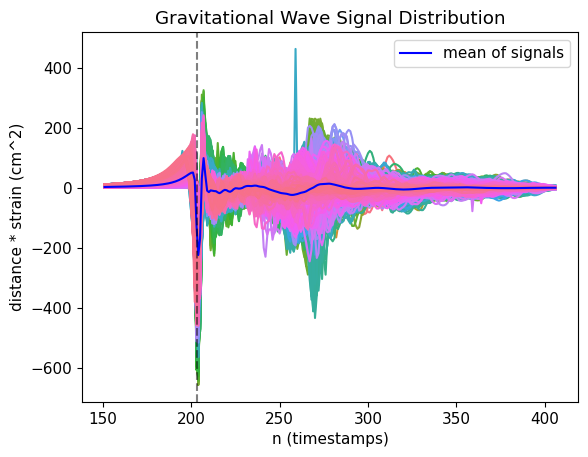

In [99]:
# convert the DataFrame from wide format to long format for seaborn
gw_df_long = pd.melt(gw_df.reset_index(), id_vars='index')

gw_df_long.columns = ['n (timestamps)', 'Line', 'distance * strain (cm^2)']

# confidence intervals
sns.lineplot(x='n (timestamps)', y='distance * strain (cm^2)', hue='Line', data=gw_df_long, errorbar=('ci', 95), n_boot=1000, legend=False)

median_line = gw_df.mean(axis=1)
plt.plot(median_line.index, median_line.values, 'b-', label='mean of signals')

# the core bounce is at n = 203
plt.axvline(x=203, color='black', linestyle='--', alpha=0.5)  

plt.title('Gravitational Wave Signal Distribution')
plt.legend()
# plt.savefig('../plots/gw_signal_distribution.png')
plt.show()

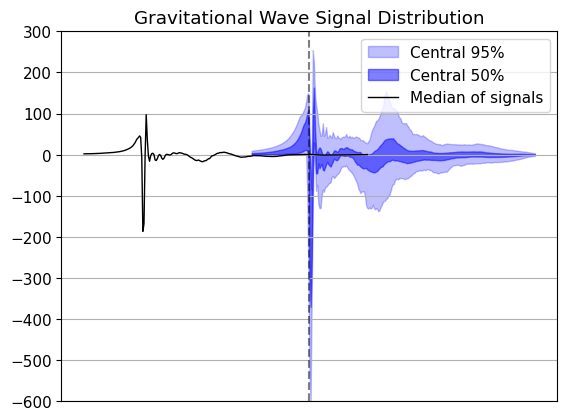

In [100]:
# Compute median of signals
median_line = gw_df.median(axis=1)

# Compute central 95% interval
percentile_2_5 = gw_df.quantile(0.025, axis=1)
percentile_97_5 = gw_df.quantile(0.975, axis=1)
plt.fill_between(median_line.index, percentile_2_5, percentile_97_5, color='blue', alpha=0.25, label='Central 95%')

# Compute central 50% interval
percentile_25 = gw_df.quantile(0.25, axis=1)
percentile_75 = gw_df.quantile(0.75, axis=1)
plt.fill_between(median_line.index, percentile_25, percentile_75, color='blue', alpha=0.5, label='Central 50%')

plt.plot(x, median_line.values, color='k', linestyle='-', linewidth=1, alpha=1.0, label='Median of signals')

# The core bounce is at n = 203
plt.axvline(x=203, color='black', linestyle='--', alpha=0.5)  
plt.ylim(-600, 300)

plt.grid(True)

plt.title('Gravitational Wave Signal Distribution')
plt.legend()

# Disable x-axis ticks
plt.xticks([])

plt.savefig('../plots/original_signal_distribution.png')
plt.show()

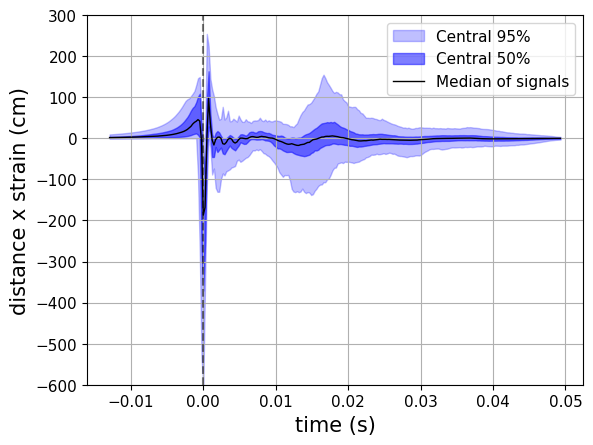

In [101]:
# Set font size globally for all plots
plt.rcParams.update({'font.size': 11})

# Compute median of signals
median_line = gw_df.median(axis=1)

# Transform x values
x = [i / 4096 for i in range(0, 256)]
x = [value - (53/4096) for value in x]

# Compute central 95% interval
percentile_2_5 = gw_df.quantile(0.025, axis=1)
percentile_97_5 = gw_df.quantile(0.975, axis=1)
plt.fill_between(x, percentile_2_5, percentile_97_5, color='blue', alpha=0.25, label='Central 95%')

# Compute central 50% interval
percentile_25 = gw_df.quantile(0.25, axis=1)
percentile_75 = gw_df.quantile(0.75, axis=1)
plt.fill_between(x, percentile_25, percentile_75, color='blue', alpha=0.5, label='Central 50%')

plt.plot(x, median_line.values, color='k', linestyle='-', linewidth=1, alpha=1.0, label='Median of signals')

# The core bounce is at n = 203
plt.axvline(x=0, color='black', linestyle='--', alpha=0.5)  

# Set the same y-axis limits
plt.ylim(-600, 300)

# Set the same x-axis labels and title
plt.xlabel('time (s)', size=15)
plt.ylabel('distance x strain (cm)', size=15)
# plt.title('Generated Stellar Core-Collapse Wave Signal Distribution', size=20)

plt.grid(True)

plt.legend()
# Save the figure
plt.savefig('../plots/original_signal_distribution_1684.pdf')
plt.show()

### Spectral Analysis 

#### Median of Signals

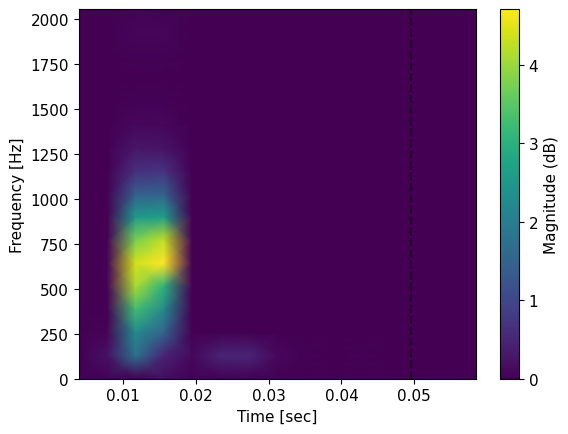

In [102]:
fs = 407/(0.04956055 * 2)
# sample_random = gw_df['V6'].values

median_gw_signals = gw_df.median(axis=1).values

window_length = 32
overlap = 16
f, t, Sxx = signal.spectrogram(median_gw_signals, fs, nperseg=window_length, noverlap=overlap)

cax = plt.pcolormesh(t, f, Sxx, shading='gouraud')
plt.colorbar(cax, label="Magnitude (dB)")

# the core bounce is at 0.04956055 s
plt.axvline(x=0.04956055, color='black', linestyle='--', alpha=0.5)  

plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

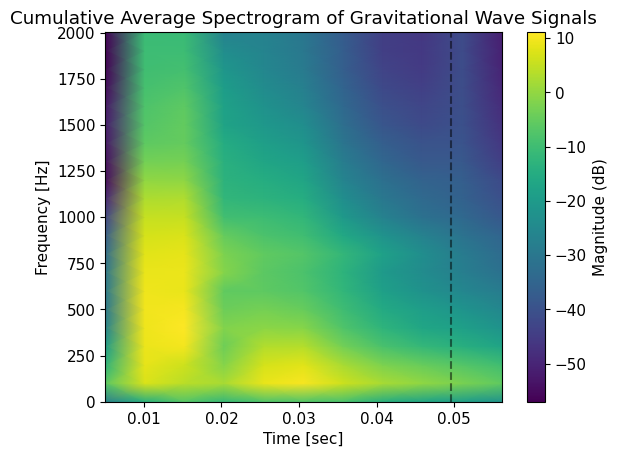

In [103]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

# Assuming gw_df contains your gravitational wave signals data
fs = 407 / (0.04956055 * 2)

# Initialize cumulative spectrogram with the shape of a single spectrogram
window_length = int(0.01 * fs)  # 1% of the total duration
overlap = int(0.005 * fs)  # 50% overlap
f, t, single_spectrogram = signal.spectrogram(gw_df.iloc[:, 0].values, fs, nperseg=window_length, noverlap=overlap)
cumulative_spectrogram = np.zeros_like(single_spectrogram)

# Compute the cumulative spectrogram for all signals
num_signals = len(gw_df.columns)
for i in range(num_signals):
    signal_values = gw_df.iloc[:, i].values
    _, _, Sxx = signal.spectrogram(signal_values, fs, nperseg=window_length, noverlap=overlap)
    cumulative_spectrogram += Sxx  # Sum the spectrogram of each signal

# Compute the cumulative average spectrogram
average_spectrogram = cumulative_spectrogram / num_signals

# Plot the cumulative average spectrogram
cax = plt.pcolormesh(t, f, 10 * np.log10(average_spectrogram), shading='gouraud')  # Convert to dB for better visualization
plt.colorbar(cax, label="Magnitude (dB)")

# The core bounce is at 0.04956055 s
plt.axvline(x=0.04956055, color='black', linestyle='--', alpha=0.5)

plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title('Cumulative Average Spectrogram of Gravitational Wave Signals')
# plt.savefig('../plots/gw_cumulative_average_spectrogram.png')
plt.show()


- Range of frequency bands around core bounce
- Peak magnitude at ~700 Hz
- Posty bounce has faint frequency band from 0.06s - 0.07s at 50 Hz

#### 16 Random Signals

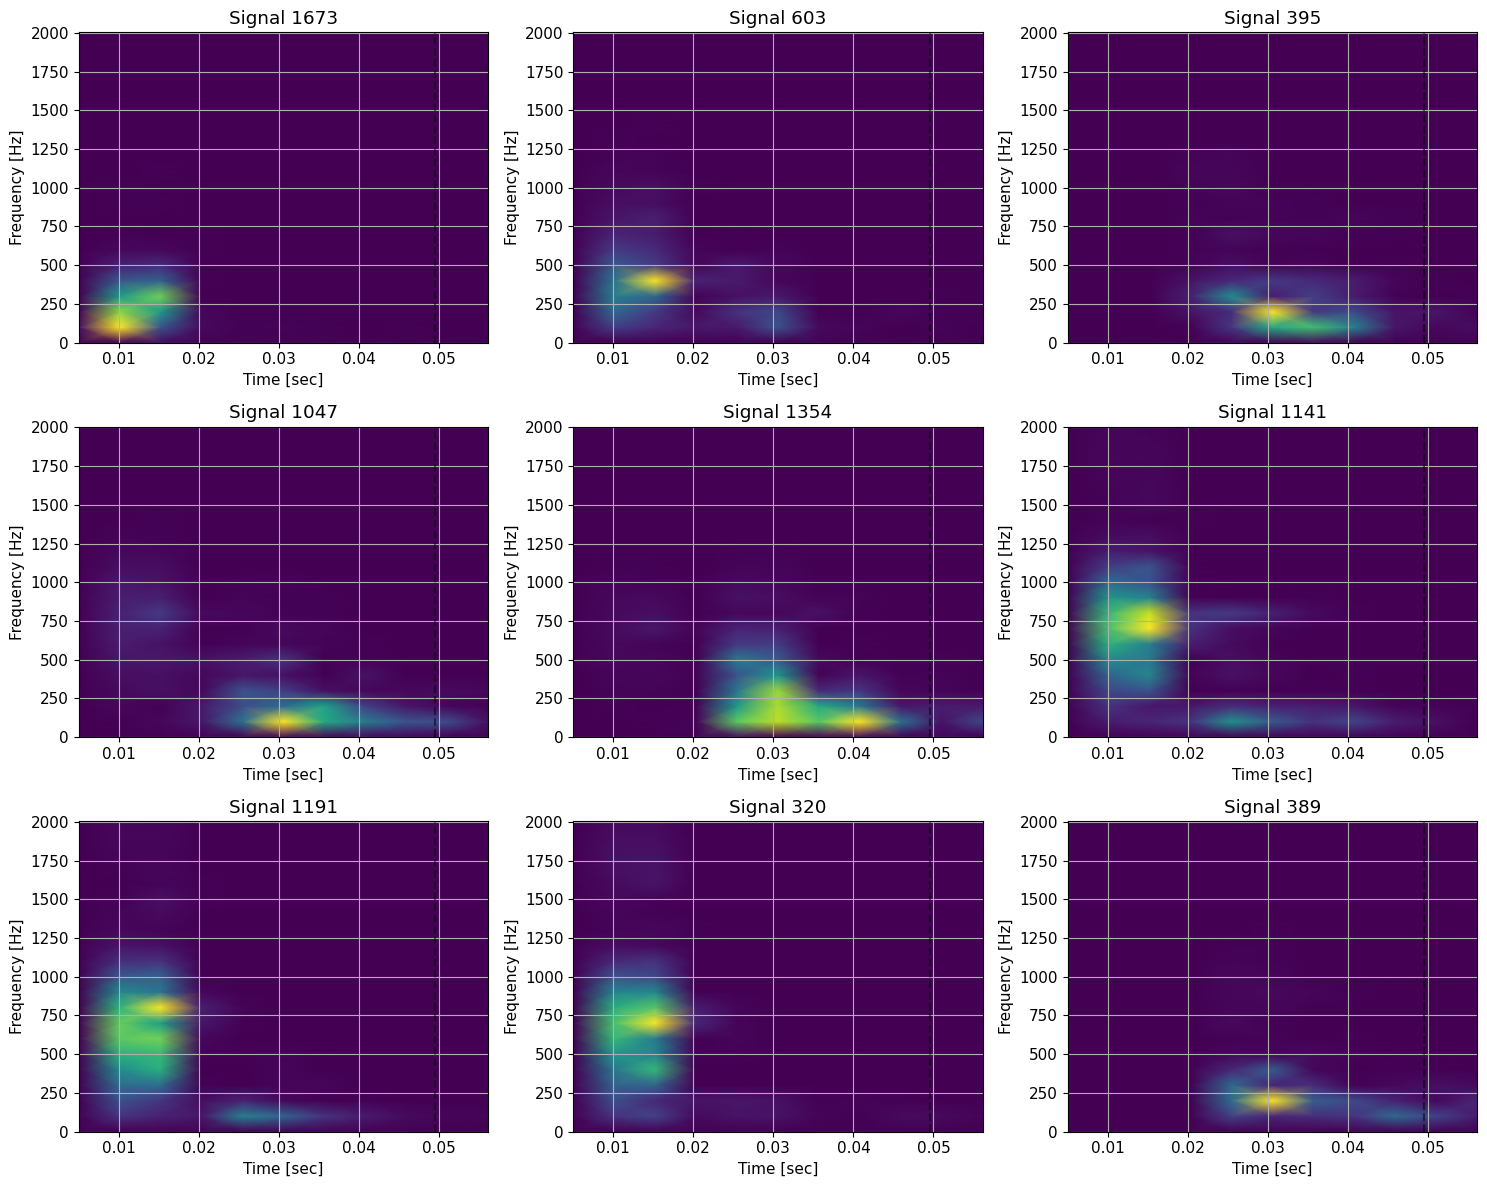

In [104]:
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 12))
axes = axes.flatten()

# Plot each signal on a separate subplot
for i, ax in enumerate(axes):
    signal_data = selected_signals.iloc[:, i].values

    f, t, Sxx = signal.spectrogram(signal_data, fs, nperseg=window_length, noverlap=overlap)

    ax.pcolormesh(t, f, Sxx, shading='gouraud')
    ax.set_ylabel('Frequency [Hz]')
    ax.set_xlabel('Time [sec]')
    
    ax.axvline(x=0.04956055, color='black', linestyle='--', alpha=0.5)
    ax.set_title(f'Signal {random_index[i]}')  # assuming columns are signal names/identifiers
    ax.grid(True)

# Delete any unused subplots
for j in range(i+1, num_rows*num_cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()